Importing everything

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomContrast, RandomFlip, RandomRotation, RandomTranslation, RandomWidth
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split


# Print TensorFlow version to confirm compatibility
print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.18.0


LOADING THE DATA

In [2]:

# Define the path to your dataset
data_dir = r'D:\School\UNI\Intelligent Systems\projects\cnn project 2.0\train'

# Load all image paths and labels
ds_all = image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

Found 31624 files belonging to 49 classes.


SPLIT INTO TRAINING AND VALIDATION

In [3]:
def split_dataset(dataset, validation_split=0.2):
    dataset_size = len(dataset)
    indices = np.arange(dataset_size)
    train_indices, val_indices = train_test_split(indices, test_size=validation_split, random_state=31415)

    train_dataset = dataset.enumerate().filter(lambda i, _: tf.reduce_any(i == train_indices)).map(lambda _, data: data)
    val_dataset = dataset.enumerate().filter(lambda i, _: tf.reduce_any(i == val_indices)).map(lambda _, data: data)
    
    return train_dataset, val_dataset

ds_train, ds_valid = split_dataset(ds_all)

DATA PIPELINE

In [4]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


DATA AUGMENTATION

In [5]:
augment = keras.Sequential([
    layers.RandomContrast(factor=(0.5, 1.5)),
    layers.RandomFlip(mode='horizontal'),  # More common for natural images
    # layers.RandomFlip(mode='vertical'),   # Uncomment only if meaningful
    layers.RandomRotation(factor=0.20),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomWidth(factor=0.15),
])

DATA AUGMENTATION VISUALIZATION


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1121378].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0592134].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09479076..1.0180786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0809729].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0446465].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0641527].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1143801].
Clipping input data to the 

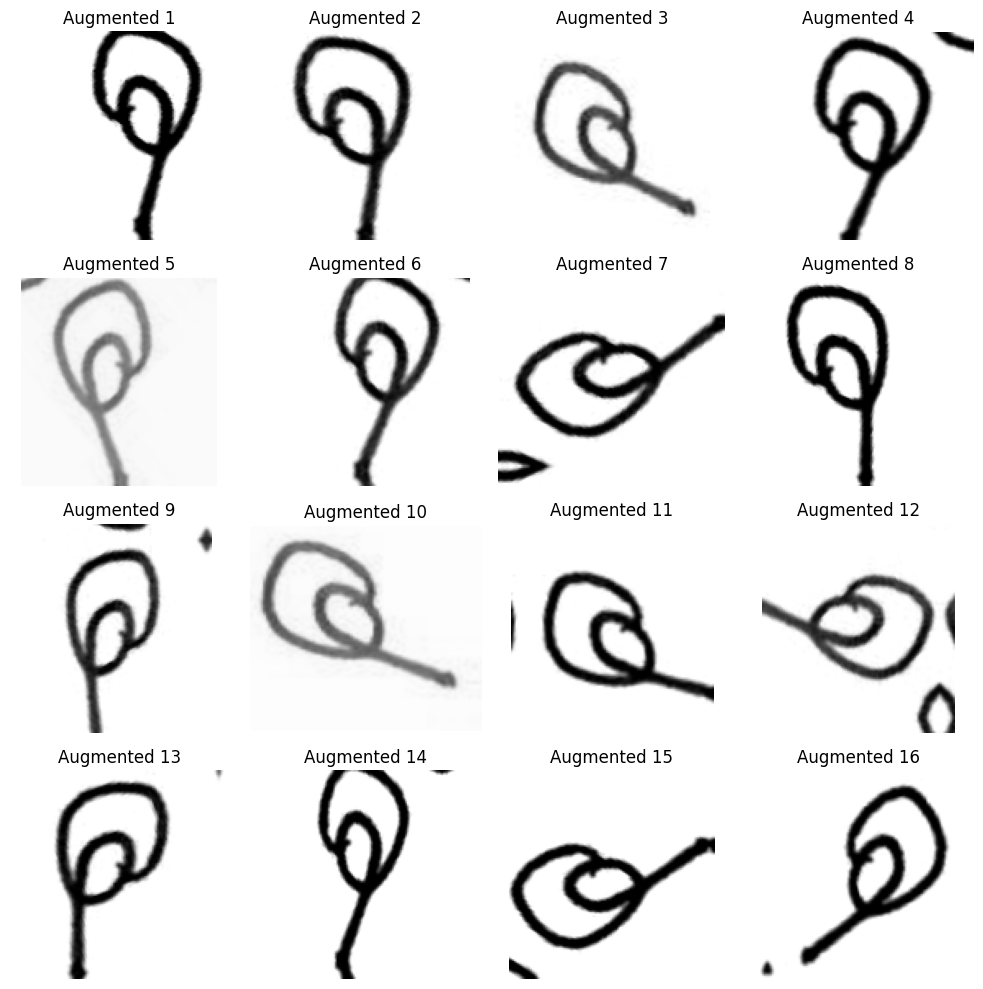

In [6]:


# Visualize Augmented Images
ex = next(iter(ds_train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10, 10))
grid_size = 4  # 4x4 grid
for i in range(grid_size**2):
    image = augment(ex, training=True)
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(tf.squeeze(image))
    plt.title(f"Augmented {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


SETTING UP THE MODEL

In [7]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Block One
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.3),

    # Block Two
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.3),

    # Block Three
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    layers.Dropout(0.4),

    # Head
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(49, activation='softmax'), 
])


d:\School\UNI\Intelligent Systems\projects\cnn project 2.0\tf_venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


OPRIMIZER AND COMPILING THE MODEL

In [8]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Use this for integer labels
    metrics=['categorical_crossentropy'],  # Match the loss function
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)




TRAINING THE MODEL

In [ ]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
)


Epoch 1/50
    177/Unknown 3080s 17s/step - categorical_crossentropy: 3.8486 - loss: 3.8486

PLOT EVRYTHING

In [ ]:
# Plot learning curves
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();